读取 41 个文件...
正在旋转数据: 磁偏角 16.0° + 构造走向 -26.2° ...
开始生成椭圆...
完成！请查看 Rotated_PT_Section-usa.png


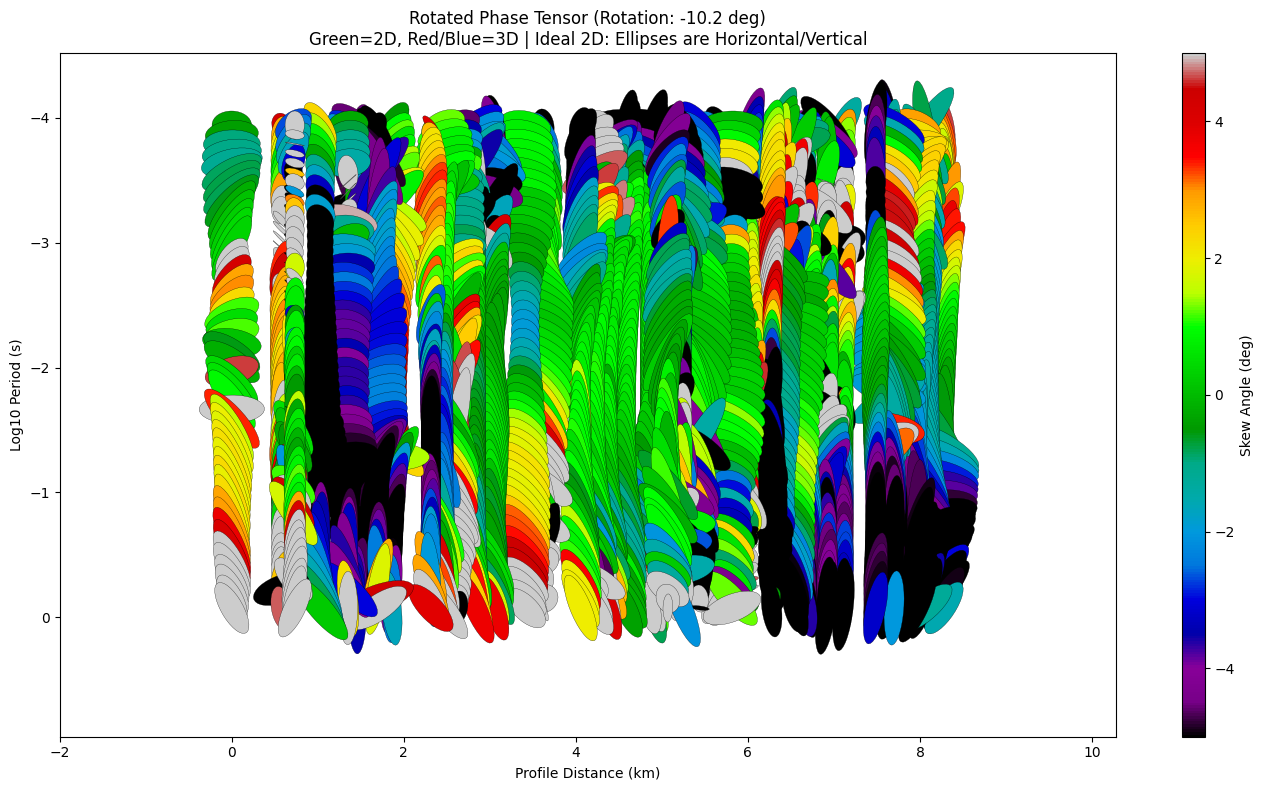

In [1]:
##### -*- coding: utf-8 -*-
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.colors import Normalize
from scipy.interpolate import interp1d

# ================= 配置区域 =================
edi_dir = r'./1china'              
freq_min, freq_max = 1, 10000    # 你的实测频率范围

# --- 关键旋转参数 ---
# 负值代表西北 (NW)，正值代表东北 (NE)
MAG_DECLINATION = 16.0    # 磁偏角 (根据当地情况，美国西北通常偏东)
PROFILE_STRIKE  = -26.2   # 构造走向 (之前算出的共轭方向)

# --- 绘图微调 ---
ELLIPSE_SIZE = 1.5       # 椭圆大小
X_STRETCH = 1.0          # 横向拉伸
Y_STRETCH = 4.0          # 纵向拉伸
SKEW_THRESHOLD = 5       # Skew颜色阈值
SKIP_STATION = 1         # 隔几个点画一个
SKIP_FREQ = 1            # 隔几个频率画一个
# ===========================================

def parse_dms(dms_str):
    """解析经纬度，自动处理负号"""
    dms_str = dms_str.strip()
    try:
        parts = dms_str.split(':')
        d, m, s = float(parts[0]), float(parts[1]), float(parts[2])
        # 判定符号：如果有负号或者度数小于0
        sign = -1 if (d < 0 or dms_str.startswith('-')) else 1
        return sign * (abs(d) + m/60.0 + s/3600.0)
    except: return 0.0

class CustomMT:
    def __init__(self, lat, lon, freqs, z_array):
        self.lat, self.lon = lat, lon
        self.freqs = np.array(freqs)
        self.Z = z_array 

    def rotate(self, angle):
        """顺时针旋转 Z 张量"""
        rad = np.deg2rad(angle)
        c, s = np.cos(rad), np.sin(rad)
        R = np.array([[c, s], [-s, c]])
        new_Z = np.zeros_like(self.Z, dtype=complex)
        for i in range(len(self.freqs)):
            new_Z[i] = R @ self.Z[i] @ R.T
        self.Z = new_Z

def read_custom_edi(file_path):
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        lines = f.readlines()
    data_map = {}
    lat, lon = 0.0, 0.0
    current_key, current_vals = None, []
    
    for line in lines:
        line = line.strip()
        if not line: continue
        if line.startswith('LAT='): lat = parse_dms(line.split('=')[1]); continue
        if line.startswith('LONG='): lon = parse_dms(line.split('=')[1]); continue
        if line.startswith('>'):
            if current_key: data_map[current_key] = np.array(current_vals)
            temp = line[1:].split('//')[0].split()[0]
            current_key = temp.replace('.', '').upper()
            current_vals = []
        else:
            if current_key:
                try: current_vals.extend([float(x) for x in line.split()])
                except: pass
    if current_key: data_map[current_key] = np.array(current_vals)
    
    # --- 修复部分 (Fix) ---
    freqs = data_map.get('FREQ')
    if freqs is None:
        freqs = data_map.get('FREQUENCIES')
    
    if freqs is None: return None
    # ---------------------
    
    n = len(freqs)
    Z = np.zeros((n, 2, 2), dtype=complex)
    for i, c1 in enumerate(['X','Y']):
        for j, c2 in enumerate(['X','Y']):
            comp = f'{c1}{c2}'
            if f'Z{comp}R' in data_map and f'Z{comp}I' in data_map:
                Z[:,i,j] = data_map[f'Z{comp}R'][:n] + 1j * data_map[f'Z{comp}I'][:n]
    
    return CustomMT(lat, lon, freqs, Z)
    
def project_stations(lats, lons, azimuth):
    # 投影到剖面方向
    lat0, lon0 = lats[0], lons[0]
    dy = (lats - lat0) * 111.0
    dx = (lons - lon0) * 111.0 * np.cos(np.deg2rad(lat0))
    rad = np.deg2rad(azimuth)
    dist = dx * np.sin(rad) + dy * np.cos(rad)
    return dist - dist.min()

# --- 2. 相位张量计算 ---
def calc_phase_tensor(Z):
    X = Z.real
    Y = Z.imag
    try:
        X_inv = np.linalg.inv(X)
        Phi = np.matmul(X_inv, Y)
    except: return None 
        
    xx, xy = Phi[0,0], Phi[0,1]
    yx, yy = Phi[1,0], Phi[1,1]
    
    tr = xx + yy
    det = xx*yy - xy*yx
    sk = xy - yx
    
    # Skew (beta)
    beta = 0.5 * np.arctan2(sk, tr) * (180/np.pi)
    
    # Alpha (走向角)
    # 注意：这里的 Alpha 是相对于当前坐标系 X 轴的角度
    alpha = 0.5 * np.arctan2(xy + yx, xx - yy) * (180/np.pi)
    
    # Principal values
    term1 = np.sqrt( (xx-yy)**2 + (xy+yx)**2 )
    phi_max = (np.sqrt(tr**2 + sk**2) + term1) / 2.0
    phi_min = (np.sqrt(tr**2 + sk**2) - term1) / 2.0
    
    return phi_max, phi_min, alpha, beta

# --- 3. 绘图主程序 ---
def plot_rotated_pt():
    files = sorted(glob.glob(os.path.join(edi_dir, '*.edi')))
    print(f"读取 {len(files)} 个文件...")
    
    mts = []
    lats, lons = [], []
    for f in files:
        m = read_custom_edi(f)
        if m:
            mts.append(m)
            lats.append(m.lat)
            lons.append(m.lon)
    
    if not mts: return

    # --- 核心：在这里进行旋转 ---
    print(f"正在旋转数据: 磁偏角 {MAG_DECLINATION}° + 构造走向 {PROFILE_STRIKE}° ...")
    total_rotation = MAG_DECLINATION + PROFILE_STRIKE
    # 如果要把 Profile 方向作为 X 轴，通常旋转 (Strike + 90) 或 Strike
    # 这里我们旋转 Strike 角度。
    # 预期效果：如果构造真的是 45 度，旋转 45 度后，椭圆长轴应该变成 0度 (水平) 或 90度 (垂直)
    
    for m in mts:
        m.rotate(total_rotation)

    # 计算投影坐标 (沿剖面方向)
    # 剖面方向通常垂直于走向 (Strike + 90)
    dists = project_stations(np.array(lats), np.array(lons), PROFILE_STRIKE + 90)
    
    # 绘图
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # 颜色 (Green=2D, Red/Blue=3D)
    norm = Normalize(vmin=-SKEW_THRESHOLD, vmax=SKEW_THRESHOLD)
    cmap = plt.cm.nipy_spectral 

    print("开始生成椭圆...")
    for idx, mt in enumerate(mts):
        if idx % SKIP_STATION != 0: continue
        x_pos = dists[idx]
        periods = 1.0 / mt.freqs
        
        for f_idx, freq in enumerate(mt.freqs):
            if f_idx % SKIP_FREQ != 0: continue
            if freq < freq_min or freq > freq_max: continue
            
            res = calc_phase_tensor(mt.Z[f_idx])
            if res is None: continue
            phmax, phmin, alpha, beta = res
            
            # 归一化椭圆大小
            # 利用反正切将值映射到 0-90 度范围，防止数值差异过大
            pmx_ang = np.degrees(np.arctan(phmax))
            pmn_ang = np.degrees(np.arctan(phmin))
            
            if pmx_ang <= 0: continue
            ratio = pmn_ang / pmx_ang
            
            base_size = 0.15 * ELLIPSE_SIZE
            width = base_size 
            height = base_size * ratio
            
            # 角度处理
            # 此时 Z 已经旋转过了。
            # 如果构造走向与旋转角度一致，alpha 应该接近 0 (水平) 或 90 (垂直)
            # 绘图坐标系中，0度通常指X轴正向(右)。
            # MTpy 中 alpha 是从 X 轴算的。
            plot_angle = -alpha # 调整方向习惯
            
            color = cmap(0.5 + 0.5 * (beta / SKEW_THRESHOLD))
            
            ell = Ellipse(
                xy=(x_pos, np.log10(periods[f_idx])),
                width=width * X_STRETCH,
                height=height * Y_STRETCH,
                angle=plot_angle,
                facecolor=color,
                edgecolor='k',
                linewidth=0.2
            )
            ax.add_patch(ell)

    ax.set_xlabel("Profile Distance (km)")
    ax.set_ylabel("Log10 Period (s)")
    ax.invert_yaxis() # 高频在上
    
    # 设置范围
    all_periods = np.concatenate([1./m.freqs for m in mts])
    ymin, ymax = np.log10(all_periods.min()), np.log10(all_periods.max())
    ax.set_ylim(ymax+0.5, ymin-0.5)
    ax.set_xlim(dists.min()-2, dists.max()+2)
    
    # 色标
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, aspect=30)
    cbar.set_label("Skew Angle (deg)")
    
    plt.title(f"Rotated Phase Tensor (Rotation: {total_rotation:.1f} deg)\nGreen=2D, Red/Blue=3D | Ideal 2D: Ellipses are Horizontal/Vertical")
    plt.tight_layout()
    plt.savefig("Rotated_PT_Section-usa.png", dpi=300)
    print("完成！请查看 Rotated_PT_Section-usa.png")
    plt.show()

if __name__ == "__main__":
    plot_rotated_pt()

In [2]:
import os
# 打印当前工作目录
print("当前工作目录:", os.getcwd())

# 打印图片的完整绝对路径
print("图片保存在:", os.path.abspath("Rotated_PT_Section-china.png"))

当前工作目录: /opt/notebooks/OTData&Application
图片保存在: /opt/notebooks/OTData&Application/Rotated_PT_Section-china.png
